In [41]:
import pandas_datareader as pdr
import datetime
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pandas_ta as ta
from xmlrpc.client import Boolean

In [42]:
def macd_strategy(symbol, start, end):
    #get data
    price = pdr.get_data_yahoo(symbol, start, end)
    price = price.drop(['Volume', 'Adj Close'], 1)

    #macd calculations
    exp1 = price.Close.ewm(span = 12, adjust=False).mean()
    exp2 = price.Close.ewm(span = 26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span = 9, adjust=False).mean()

    #add column for entries
    price['Long'] = macd > signal
    # profit calculation for MACD
    money = 10000
    exchange = 0
    wins= 0
    asset = [10000]
    numb=0
    drawdowns = [0]
    difference = []
    for i in range(1, len(price)):
        
        if price['Long'][i] == True:
            
            if numb==0:
                buy = price['Close'][i]
                numb = money//buy
                money-=numb*buy
            else:
                asset.append(money + (price['Close'][i]*numb))
                drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
                continue
        else:
           
            if numb!=0 : 
                sell = price['Close'][i]
                money += (sell)*numb
                exchange +=1
                if sell>buy:
                    wins +=1
                difference.append(sell-buy)
                numb=0
            else: 
                
                asset.append(money + (price['Close'][i]*numb))
                drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
                continue
        
        asset.append(money + (price['Close'][i]*numb))
        drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
    price['MACD']=asset
    price['DD']=drawdowns

    STARTING_BALANCE = 10000
    #daily return
    price['Return'] = price.Close / price.Close.shift(1)
    price.Return.iat[0] = 1
    price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()
    #calculate drawdown
    price['Bench_Peak'] = price.Bench_Bal.cummax()
    price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak

    bench_dd = round((price.Bench_DD / price.Bench_Peak).min() * 100, 2)
    print("win rate:", wins/exchange)
    print("strategy maximum drawdown", min(price['DD']))
    print("benchmarck maximum drawdwon", bench_dd)
    return price
    
    

In [43]:

def rsi_strategy(symbol, start, end):
    #get data
    price = pdr.get_data_yahoo(symbol, start, end)
    price = price.drop(['Volume', 'Adj Close'], 1)
    rsi = price.ta.rsi(close='Close', length=14, append=True, signal_indicators = True, xa=70, xb=30)
    RSIs=[]
    for i in price['RSI_14_B_30']:
        RSIs.append(Boolean(i))
    RSI= pd.Series(RSIs)
    # profit calculation for RSI
    money = 10000
    exchange = 0
    wins= 0
    drawdowns = [0]
    asset = [10000]
    numb=0
    rsi_index = []
    for i in range(1, len(price)):
        if price['RSI_14_B_30'][i]==1 and numb==0:
            rsi_index.append(i)
            buy = price['Close'][i]
            numb = money//buy
            money-=numb*buy
            asset.append(money + (price['Close'][i]*numb))
            drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
            continue

        if price['RSI_14_A_70'][i]==1 and numb !=0:
            sell = price['Close'][i]
            money += (sell)*numb
            exchange +=1
            if sell>buy:
                wins +=1
            numb=0
            asset.append(money + (price['Close'][i]*numb))
            drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
            continue
            
        asset.append(money + (price['Close'][i]*numb))
        drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))

        
    price['RSI_strategy'] = asset
    price['DD']=drawdowns
    print("strategy maximum drawdown", min(price['DD']))
    return price



In [44]:


def bollinger_band_strategy(symbol, start, end):
    def get_sma(prices, rate):
        return prices.rolling(rate).mean()
    price = pdr.DataReader(symbol, 'yahoo', start, end)
    closing_prices = price['Close'] 
    ma = get_sma(closing_prices, 20)
    def get_bollinger_bands(prices, rate=20):
        sma = get_sma(prices, rate)
        std = prices.rolling(rate).std()
        bollinger_up = sma + std * 2 # Calculate top band
        bollinger_down = sma - std * 2 # Calculate bottom band
        return bollinger_up, bollinger_down

    bollinger_up, bollinger_down = get_bollinger_bands(closing_prices)

    # backtrading for bollinger bands
    money = 10000
    exchange = 0
    wins= 0
    asset = [10000]
    numb=0
    bollinger_up, bollinger_down = get_bollinger_bands(price['Close'])

    for i in range(1, len(price)):
        if bollinger_down[i]:
            if price['Close'][i] < bollinger_down[i] and numb==0:
                buy = price['Close'][i]
                numb = money//buy
                money-=numb*buy
            elif price['Close'][i] > bollinger_up[i] and numb!=0:
                sell = price['Close'][i]
                money += (sell)*numb
                exchange +=1
                if sell>buy:
                    wins +=1
                numb=0
            else:
                asset.append(money + (price['Close'][i]*numb))
                continue
        else:
            asset.append(money + (price['Close'][i]*numb))
            continue
        asset.append(money + (price['Close'][i]*numb))

    price['Bollinger'] = asset
    return price



In [45]:
# profit calculation for volatility breakout strategy
def breakout_strategy(symbol, start, end,k):
    price = pdr.get_data_yahoo(symbol, start, end)
    price = price.drop(['Volume', 'Adj Close'], 1)
    money = 10000
    exchange = 0
    wins= 0
    asset = [10000]
    numb=0
    profit=0
    for i in range( len(price)-1):
        volatility = abs(price['High'][i-1]-price['Low'][i-1])
        k=0.3
        if price['High'][i]>price['Open'][i]+(volatility*k):
            buy = price['Open'][i]+(volatility*k)
            numb = money//buy
            sell = price['Close'][i]
            profit = (sell-buy)*numb
            exchange +=1
            if sell>buy:
                wins +=1

        numb=0
        money +=profit
        
        profit=0
        asset.append(money)
    price['breakout'] = asset
    return price



In [46]:
def MACD_BREAKOUT_STRATEGY(symbol, start, end, k):
    #get data
    price = pdr.get_data_yahoo(symbol, start, end)
    price = price.drop(['Volume', 'Adj Close'], 1)

    #macd calculations
    exp1 = price.Close.ewm(span = 12, adjust=False).mean()
    exp2 = price.Close.ewm(span = 26, adjust=False).mean()
    exp3 = price.Close.ewm(span = 26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span = 9, adjust=False).mean()

    #add column for entries
    price['Long'] = macd > signal
    price['200ema']=exp3
    # profit calculation for MACD
    money = 10000
    exchange = 0
    wins= 0
    asset = [10000]
    numb=0
    difference = []
    for i in range(1, len(price)):
        
        if price['Long'][i] == True:
            
            if numb==0:
                buy = price['Close'][i]
                numb = money//buy
                money-=numb*buy
            else:
                asset.append(money + (price['Close'][i]*numb))
                continue
        elif price['High'][i]>price['Open'][i]+(price['High'][i-1]-price['Low'][i-1] )*k :
            if numb==0:
                buy = price['Open'][i]+(price['High'][i-1]-price['Low'][i-1] )*k
                numb = money//buy
                money-=numb*buy
            else:
                asset.append(money + (price['Close'][i]*numb))
                continue
        else:
           
            if numb!=0 : 
                sell = price['Close'][i]
                money += (sell)*numb
                exchange +=1
                if sell>buy:
                    wins +=1
                difference.append(sell-buy)
                numb=0
            else: 
                
                asset.append(money + (price['Close'][i]*numb))
                continue
        asset.append(money + (price['Close'][i]*numb))
    price['MACD']=asset
    return price

In [47]:
start =datetime.datetime(2021, 1, 1)
end= datetime.datetime(2022, 10, 12)
symbol = 'AAPL'
result_macd= macd_strategy(symbol, start, end)
result_macd

win rate: 0.5454545454545454
strategy maximum drawdown -0.17139117429885437
benchmarck maximum drawdwon -28.54


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_42437/2337481255.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


,High,Low,Open,Close,Long,MACD,DD,Return,Bench_Bal,Bench_Peak,Bench_DD
Date,,,,,,,,,,,
2020-12-31,134.740005,131.720001,134.080002,132.690002,False,10000.000000,0.000000,1.000000,10000.000000,10000.000000,0.000000
2021-01-04,133.610001,126.760002,133.520004,129.410004,False,10000.000000,0.000000,0.975281,9752.807392,10000.000000,-247.192608
2021-01-05,131.740005,128.429993,128.889999,131.009995,False,10000.000000,0.000000,1.012364,9873.388507,10000.000000,-126.611493
2021-01-06,131.050003,126.379997,127.720001,126.599998,False,10000.000000,0.000000,0.966338,9541.035206,10000.000000,-458.964794
2021-01-07,131.630005,127.860001,128.360001,130.919998,False,10000.000000,0.000000,1.034123,9866.606056,10000.000000,-133.393944
...,...,...,...,...,...,...,...,...,...,...,...
2022-10-06,147.539993,145.220001,145.809998,145.429993,False,14541.689995,-0.039643,0.993374,10960.131886,13716.933541,-2756.801655
2022-10-07,143.100006,139.449997,142.539993,140.089996,False,14541.689995,-0.039643,0.963281,10557.690388,13716.933541,-3159.243153
2022-10-10,141.889999,138.570007,140.419998,140.419998,False,14541.689995,-0.039643,1.002356,10582.560523,13716.933541,-3134.373018


In [48]:
# here! we combine all the results
start =datetime.datetime(2021, 1, 1)
end= datetime.datetime(2022, 10, 12)
#symbol = 'AAPL'

import random
df = pd.read_csv('constituents_csv.csv')
random_number = random.randint(1,500)
symbol = df['Symbol'][random_number]

# Python3 code to demonstrate working of
# Random K dates in Range
# Using randrange() + timedelta() + loop
from datetime import date, timedelta

# initializing dates ranges 
test_date1, test_date2 = date(2011, 1, 1), date(2021, 10, 1)
  
# printing dates 
print("The original range : " + str(test_date1) + " " + str(test_date2))
  
# getting days between dates
dates_bet = test_date2 - test_date1
total_days = dates_bet.days
  
random.seed(a=None)
randay = random.randrange(total_days)
start = test_date1 + timedelta(days=randay)
end = start.replace(start.year + 1)


price = pdr.get_data_yahoo(symbol, start, end)
result_macd= macd_strategy(symbol, start, end)
result_rsi = rsi_strategy(symbol, start, end)
result_bollinger = bollinger_band_strategy(symbol, start,end)
result_breakout = breakout_strategy(symbol, start, end,0.5)
result = MACD_BREAKOUT_STRATEGY(symbol, start, end, 0.5)
print(symbol)
#result_macd_breakout = macd_breakout_strategy(symbol, start, end, 0.3)

The original range : 2011-01-01 2021-10-01


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_42437/2337481255.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


win rate: 0.3333333333333333
strategy maximum drawdown -0.05752754425888113
benchmarck maximum drawdwon -10.25
strategy maximum drawdown -0.03849703963299367


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_42437/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


SLG


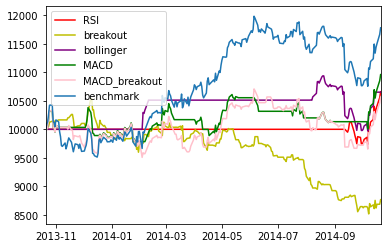

In [49]:
#visualize
plt.plot(result_rsi['RSI_strategy'],c='r', label="RSI")
plt.plot(result_breakout['breakout'],c='y', label = "breakout")
plt.plot(result_bollinger['Bollinger'], c = 'purple', label = "bollinger")
plt.plot(result_macd['MACD'],c='g', label = 'MACD')
plt.plot(result['MACD'], c='pink', label = 'MACD_breakout')
plt.plot(result_rsi['Close']*(10000/result_rsi['Close'][0]), label = "benchmark")
plt.xlim(start,end)
plt.legend()
plt.show()

In [50]:
df

,Symbol,Name,Sector
0,MMM,3M Company,Industrials
1,AOS,A.O. Smith Corp,Industrials
2,ABT,Abbott Laboratories,Health Care
3,ABBV,AbbVie Inc.,Health Care
4,ACN,Accenture plc,Information Technology
...,...,...,...
500,XYL,Xylem Inc.,Industrials
501,YUM,Yum! Brands Inc,Consumer Discretionary
502,ZBH,Zimmer Biomet Holdings,Health Care
503,ZION,Zions Bancorp,Financials


In [51]:
((result_macd['MACD'][-1]/10000)*100)

109.60066596984863

In [54]:
import random
from datetime import date, timedelta
df = pd.read_csv('constituents_csv.csv')
test_date1, test_date2 = date(2012, 1, 1), date(2021, 1, 1)

cum_benchmark = []
cum_macd = []
cum_rsi = []
cum_bollinger = []
cum_breakout = []
cum_macd_breakout =[]

cum_benchmark_L = []
cum_macd_L = []
cum_rsi_L = []
cum_bollinger_L = []
cum_breakout_L = []
cum_macd_breakout_L =[]

cum_benchmark_W = []
cum_macd_W = []
cum_rsi_W = []
cum_bollinger_W = []
cum_breakout_W = []
cum_macd_breakout_W =[]


for i in range(15):
    random_number = random.randint(1,500)
    symbol = df['Symbol'][random_number]
    
    # getting days between dates
    dates_bet = test_date2 - test_date1
    total_days = dates_bet.days
    random.seed(a=None)
    randay = random.randrange(total_days)
    start = test_date1 + timedelta(days=randay)
    end = start.replace(start.year + 1)
    try:
        print("Testing in date range : " + str(start) + " " + str(end) +"for " + str(symbol))
        price = pdr.get_data_yahoo(symbol, start, end)
        result_macd= macd_strategy(symbol, start, end)
        result_rsi = rsi_strategy(symbol, start, end)
        result_bollinger = bollinger_band_strategy(symbol, start,end)
        result_breakout = breakout_strategy(symbol, start, end,0.5)
        result = MACD_BREAKOUT_STRATEGY(symbol, start, end, 0.5)
        cum_benchmark.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
        cum_macd.append((result_macd['MACD'][-1]/10000)*100)
        cum_rsi.append((result_rsi['RSI_strategy'][-1]/10000)*100)
        cum_bollinger.append((result_bollinger['Bollinger'][-1]/10000)*100)
        cum_breakout.append((result_breakout['breakout'][-1]/10000)*100)
        cum_macd_breakout.append((result['MACD'][-1]/10000)*100)

        if (result_rsi['Close'][-1]/result_rsi['Close'][0])>1:
            cum_benchmark_W.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
            cum_macd_W.append((result_macd['MACD'][-1]/10000)*100)
            cum_rsi_W.append((result_rsi['RSI_strategy'][-1]/10000)*100)
            cum_bollinger_W.append((result_bollinger['Bollinger'][-1]/10000)*100)
            cum_breakout_W.append((result_breakout['breakout'][-1]/10000)*100)
            cum_macd_breakout_W.append((result['MACD'][-1]/10000)*100)
        else: 
            cum_benchmark_L.append(((result_rsi['Close'][-1]/result_rsi['Close'][0]))*100)
            cum_macd_L.append((result_macd['MACD'][-1]/10000)*100)
            cum_rsi_L.append((result_rsi['RSI_strategy'][-1]/10000)*100)
            cum_bollinger_L.append((result_bollinger['Bollinger'][-1]/10000)*100)
            cum_breakout_L.append((result_breakout['breakout'][-1]/10000)*100)
            cum_macd_breakout_L.append((result['MACD'][-1]/10000)*100)
    except:
        print("data not existing")
cumulative = (sum(cum_benchmark)/len(cum_benchmark),sum(cum_macd)/len(cum_macd),sum(cum_rsi)/len(cum_rsi),sum(cum_bollinger)/len(cum_bollinger),sum(cum_breakout)/len(cum_breakout),sum(cum_macd_breakout)/len(cum_macd_breakout))
cumulative_W = (sum(cum_benchmark_W)/len(cum_benchmark_W),sum(cum_macd_W)/len(cum_macd_W),sum(cum_rsi_W)/len(cum_rsi_W),sum(cum_bollinger_W)/len(cum_bollinger_W),sum(cum_breakout_W)/len(cum_breakout_W),sum(cum_macd_breakout_W)/len(cum_macd_breakout_W))
cumulative_L = (sum(cum_benchmark_L)/len(cum_benchmark_L),sum(cum_macd_L)/len(cum_macd_L),sum(cum_rsi_L)/len(cum_rsi_L),sum(cum_bollinger_L)/len(cum_bollinger_L),sum(cum_breakout_L)/len(cum_breakout_L),sum(cum_macd_breakout_L)/len(cum_macd_breakout_L))
print(cumulative_W)

Testing in date range : 2016-01-23 2017-01-23for QRVO


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_42437/2337481255.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


win rate: 0.18181818181818182
strategy maximum drawdown -0.371828944889439
benchmarck maximum drawdwon -21.18
strategy maximum drawdown -0.028323126834864043


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_42437/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2020-10-14 2021-10-14for GGP
data not existing
Testing in date range : 2017-06-23 2018-06-23for DTE
win rate: 0.2727272727272727
strategy maximum drawdown -0.12381604694009526
benchmarck maximum drawdwon -18.36
strategy maximum drawdown -0.13487430674811993


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_42437/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2020-08-08 2021-08-08for UPS
win rate: 0.4
strategy maximum drawdown -0.08360074422781708
benchmarck maximum drawdwon -12.45
strategy maximum drawdown -0.02432702178955078


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_42437/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2020-01-02 2021-01-02for SNA
win rate: 0.5555555555555556
strategy maximum drawdown -0.24132537010069105
benchmarck maximum drawdwon -43.81
strategy maximum drawdown -0.4124539029547138


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_42437/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2016-02-21 2017-02-21for DPS
data not existing
Testing in date range : 2017-06-08 2018-06-08for ESS
win rate: 0.21428571428571427
strategy maximum drawdown -0.2438628701817518
benchmarck maximum drawdwon -19.15
strategy maximum drawdown -0.16716491572919726


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_42437/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2013-03-25 2014-03-25for FITB
win rate: 0.45454545454545453
strategy maximum drawdown -0.07325710810300252
benchmarck maximum drawdwon -11.12
strategy maximum drawdown 0.0


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_42437/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2013-07-13 2014-07-13for FOX
data not existing
Testing in date range : 2020-01-25 2021-01-25for CCI
win rate: 0.2727272727272727
strategy maximum drawdown -0.24807766156800054
benchmarck maximum drawdwon -30.39
strategy maximum drawdown -0.28196542187887486


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_42437/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2020-02-14 2021-02-14for GIS
win rate: 0.23076923076923078
strategy maximum drawdown -0.2138144269046056
benchmarck maximum drawdwon -20.76
strategy maximum drawdown -0.13265875884343628


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_42437/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2013-11-04 2014-11-04for CTAS
win rate: 0.5714285714285714
strategy maximum drawdown -0.060741806957672895
benchmarck maximum drawdwon -8.68
strategy maximum drawdown 0.0


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_42437/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2018-06-25 2019-06-25for LLY
win rate: 0.625
strategy maximum drawdown -0.0665861806996864
benchmarck maximum drawdwon -14.72
strategy maximum drawdown -0.06718065021023806


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_42437/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2014-01-27 2015-01-27for PM
win rate: 0.4166666666666667
strategy maximum drawdown -0.05857948142495609
benchmarck maximum drawdwon -11.97
strategy maximum drawdown -0.042707959479476185


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_42437/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


Testing in date range : 2014-09-27 2015-09-27for ABBV
win rate: 0.2
strategy maximum drawdown -0.17618192414063344
benchmarck maximum drawdwon -21.75
strategy maximum drawdown -0.13542150144579132


/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_42437/2752916642.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


(122.21531538952559, 105.71246221860252, 105.72047834184436, 115.31844511244032, 109.36394270865121, 112.5482666815652)


<BarContainer object of 6 artists>

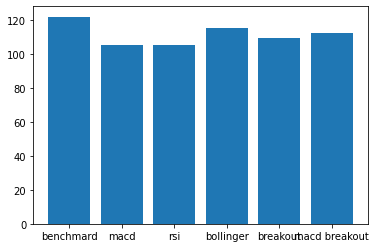

In [59]:
plt.bar(['benchmard','macd','rsi','bollinger','breakout','macd breakout'],cumulative_W)

In [4]:
pip install dateparser

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.5/290.5 kB 6.3 MB/s eta 0:00:0000:01
  Using cached tzlocal-4.2-py3-none-any.whl (19 kB)
  Using cached pytz_deprecation_shim-0.1.0.post0-py2.py3-none-any.whl (15 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.7/336.7 kB 10.6 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
Note: you may need to restart the kernel to use updated packages.


In [60]:
import feedparser
from bs4 import BeautifulSoup
import urllib
from dateparser import parse as parse_date
import requests



class GoogleNews:
    def __init__(self, lang = 'en', country = 'US'):
        self.lang = lang.lower()
        self.country = country.upper()
        self.BASE_URL = 'https://news.google.com/rss'

    def __top_news_parser(self, text):
        """Return subarticles from the main and topic feeds"""
        try:
            bs4_html = BeautifulSoup(text, "html.parser")
            # find all li tags
            lis = bs4_html.find_all('li')
            sub_articles = []
            for li in lis:
                try:
                    sub_articles.append({"url": li.a['href'],
                                         "title": li.a.text,
                                         "publisher": li.font.text})
                except:
                    pass
            return sub_articles
        except:
            return text

    def __ceid(self):
        """Compile correct country-lang parameters for Google News RSS URL"""
        return '?ceid={}:{}&hl={}&gl={}'.format(self.country,self.lang,self.lang,self.country)

    def __add_sub_articles(self, entries):
        for i, val in enumerate(entries):
            if 'summary' in entries[i].keys():
                entries[i]['sub_articles'] = self.__top_news_parser(entries[i]['summary'])
            else:
                entries[i]['sub_articles'] = None
        return entries

    def __scaping_bee_request(self, api_key, url):
        response = requests.get(
            url="https://app.scrapingbee.com/api/v1/",
            params={
                "api_key": api_key,
                "url": url,
                "render_js": "false"
            }
        )
        if response.status_code == 200:
            return response
        if response.status_code != 200:
            raise Exception("ScrapingBee status_code: "  + str(response.status_code) + " " + response.text)

    def __parse_feed(self, feed_url, proxies=None, scraping_bee = None):

        if scraping_bee and proxies:
            raise Exception("Pick either ScrapingBee or proxies. Not both!")

        if proxies:
            r = requests.get(feed_url, proxies = proxies)
        else:
            r = requests.get(feed_url)

        if scraping_bee:
            r = self.__scaping_bee_request(url = feed_url, api_key = scraping_bee)
        else:
            r = requests.get(feed_url)


        if 'https://news.google.com/rss/unsupported' in r.url:
            raise Exception('This feed is not available')

        d = feedparser.parse(r.text)

        if not scraping_bee and not proxies and len(d['entries']) == 0:
            d = feedparser.parse(feed_url)

        return dict((k, d[k]) for k in ('feed', 'entries'))

    def __search_helper(self, query):
        return urllib.parse.quote_plus(query)

    def __from_to_helper(self, validate=None):
        try:
            validate = parse_date(validate).strftime('%Y-%m-%d')
            return str(validate)
        except:
            raise Exception('Couldnt parse your date')



    def top_news(self, proxies=None, scraping_bee = None):
        """Return a list of all articles from the main page of Google News
        given a country and a language"""
        d = self.__parse_feed(self.BASE_URL + self.__ceid(), proxies=proxies, scraping_bee=scraping_bee)
        d['entries'] = self.__add_sub_articles(d['entries'])
        return d

    def topic_headlines(self, topic: str, proxies=None, scraping_bee=None):
        """Return a list of all articles from the topic page of Google News
        given a country and a language"""
        #topic = topic.upper()
        if topic.upper() in ['WORLD', 'NATION', 'BUSINESS', 'TECHNOLOGY', 'ENTERTAINMENT', 'SCIENCE', 'SPORTS', 'HEALTH']:
            d = self.__parse_feed(self.BASE_URL + '/headlines/section/topic/{}'.format(topic.upper()) + self.__ceid(), proxies = proxies, scraping_bee=scraping_bee)

        else:
            d = self.__parse_feed(self.BASE_URL + '/topics/{}'.format(topic) + self.__ceid(), proxies = proxies, scraping_bee=scraping_bee)

        d['entries'] = self.__add_sub_articles(d['entries'])
        if len(d['entries']) > 0:
            return d
        else:
            raise Exception('unsupported topic')

    def geo_headlines(self, geo: str, proxies=None, scraping_bee=None):
        """Return a list of all articles about a specific geolocation
        given a country and a language"""
        d = self.__parse_feed(self.BASE_URL + '/headlines/section/geo/{}'.format(geo) + self.__ceid(), proxies = proxies, scraping_bee=scraping_bee)

        d['entries'] = self.__add_sub_articles(d['entries'])
        return d

    def search(self, query: str, helper = True, when = None, from_ = None, to_ = None, proxies=None, scraping_bee=None):
        """
        Return a list of all articles given a full-text search parameter,
        a country and a language

        :param bool helper: When True helps with URL quoting
        :param str when: Sets a time range for the artiles that can be found
        """

        if when:
            query += ' when:' + when

        if from_ and not when:
            #from_ = self.__from_to_helper(validate=from_)
            query += ' after:' + from_

        if to_ and not when:
            #to_ = self.__from_to_helper(validate=to_)
            query += ' before:' + to_

        if helper == True:
            query = self.__search_helper(query)

        search_ceid = self.__ceid()
        search_ceid = search_ceid.replace('?', '&')

        d = self.__parse_feed(self.BASE_URL + '/search?q={}'.format(query) + search_ceid, proxies = proxies, scraping_bee=scraping_bee)

        d['entries'] = self.__add_sub_articles(d['entries'])
        return d

In [63]:
import pandas as pd
import datetime

gn = GoogleNews()

def get_news(search):
    stories = []
    start_date = datetime.date(2022,9,8)
    end_date = datetime.date(2022,9,24)
    delta = datetime.timedelta(days=1)
    date_list = pd.date_range(start_date, end_date).tolist()
    
    for date in date_list[:-1]:
        result = gn.search(search, from_=date.strftime('%Y-%m-%d'), to_=(date+delta).strftime('%Y-%m-%d'))
        newsitem = result['entries']

        for item in newsitem:
            story = {
                'title':item.title,
                
            }
            stories.append(story)
    return stories

df = pd.DataFrame(get_news('AAPL'))

In [64]:
df

,title
0,AAPL Stock Will Rise as Consumers Search to Pr...
1,AAPL Stock Alert: 13 Takeaways From the Latest...
2,Why Apple Fell Today - The Motley Fool
3,Apple Introduces iPhone 14 With Satellite Comm...
4,Apple Analyst Sees iPhone 14 Boost From Pent U...
...,...
793,Best Stocks to Day Trade • (Volatility and Sub...
794,"Microsoft: Trading At An 18-Month Low, Stock I..."
795,Starbucks' New CEO Rally Has Become Cold Brewe...
796,Group Asking FCC to Make Switching Carriers Ea...


In [8]:
pip install nltk==3.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394471 sha256=e251d0607089f675229b8b9929d876689a1afb796a6674cec63a8bc9e7239083
  Stored in directory: /Users/haechan/Library/Caches/pip/wheels/b5/0e/53/5cfbc5d26eca272bf9e6694836529448e7724765b6ae040d79
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7
Note: you may need to restart the kernel to use updated packages.


In [10]:
import nltk

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      28 non-null     object
 1   link       28 non-null     object
 2   published  28 non-null     object
dtypes: object(3)
memory usage: 800.0+ bytes


In [65]:
df['title'] = df['title'].astype(str).str.lower()
df.head(3)

,title
0,aapl stock will rise as consumers search to pr...
1,aapl stock alert: 13 takeaways from the latest...
2,why apple fell today - the motley fool


In [66]:
from nltk.tokenize import RegexpTokenizer

regexp = RegexpTokenizer('\w+')

df['text_token']=df['title'].apply(regexp.tokenize)
df.head(3)

,title,text_token
0,aapl stock will rise as consumers search to pr...,"[aapl, stock, will, rise, as, consumers, searc..."
1,aapl stock alert: 13 takeaways from the latest...,"[aapl, stock, alert, 13, takeaways, from, the,..."
2,why apple fell today - the motley fool,"[why, apple, fell, today, the, motley, fool]"


In [67]:
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/haechan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [68]:
from nltk.corpus import stopwords

# Make a list of english stopwords
stopwords = nltk.corpus.stopwords.words("english")

# Extend the list with your own custom stopwords
my_stopwords = ['https']
stopwords.extend(my_stopwords)

In [69]:
# Remove stopwords
df['text_token'] = df['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
df.head(3)

,title,text_token
0,aapl stock will rise as consumers search to pr...,"[aapl, stock, rise, consumers, search, preorde..."
1,aapl stock alert: 13 takeaways from the latest...,"[aapl, stock, alert, 13, takeaways, latest, ap..."
2,why apple fell today - the motley fool,"[apple, fell, today, motley, fool]"


In [70]:

df['text_string'] = df['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))

In [71]:
df[['title', 'text_token', 'text_string']].head()

,title,text_token,text_string
0,aapl stock will rise as consumers search to pr...,"[aapl, stock, rise, consumers, search, preorde...",aapl stock rise consumers search preorder ipho...
1,aapl stock alert: 13 takeaways from the latest...,"[aapl, stock, alert, 13, takeaways, latest, ap...",aapl stock alert takeaways latest apple event ...
2,why apple fell today - the motley fool,"[apple, fell, today, motley, fool]",apple fell today motley fool
3,apple introduces iphone 14 with satellite comm...,"[apple, introduces, iphone, 14, satellite, com...",apple introduces iphone satellite communicatio...
4,apple analyst sees iphone 14 boost from pent u...,"[apple, analyst, sees, iphone, 14, boost, pent...",apple analyst sees iphone boost pent demand sa...


In [72]:
all_words = ' '.join([word for word in df['text_string']])
tokenized_words = nltk.tokenize.word_tokenize(all_words)
from nltk.probability import FreqDist

fdist = FreqDist(tokenized_words)
fdist

FreqDist({'apple': 277, 'stock': 154, 'iphone': 117, 'nasdaq': 114, 'appleinsider': 114, 'stocks': 108, 'benzinga': 86, 'yahoo': 86, 'finance': 85, 'bloomberg': 71, ...})

In [73]:
df['text_string_fdist'] = df['text_token'].apply(lambda x: ' '.join([item for item in x if fdist[item] >= 1 ]))

In [74]:
df[['title', 'text_token', 'text_string', 'text_string_fdist']].head()

,title,text_token,text_string,text_string_fdist
0,aapl stock will rise as consumers search to pr...,"[aapl, stock, rise, consumers, search, preorde...",aapl stock rise consumers search preorder ipho...,aapl stock rise consumers search preorder ipho...
1,aapl stock alert: 13 takeaways from the latest...,"[aapl, stock, alert, 13, takeaways, latest, ap...",aapl stock alert takeaways latest apple event ...,aapl stock alert takeaways latest apple event ...
2,why apple fell today - the motley fool,"[apple, fell, today, motley, fool]",apple fell today motley fool,apple fell today motley fool
3,apple introduces iphone 14 with satellite comm...,"[apple, introduces, iphone, 14, satellite, com...",apple introduces iphone satellite communicatio...,apple introduces iphone satellite communicatio...
4,apple analyst sees iphone 14 boost from pent u...,"[apple, analyst, sees, iphone, 14, boost, pent...",apple analyst sees iphone boost pent demand sa...,apple analyst sees iphone boost pent demand sa...


In [26]:
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /Users/haechan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/haechan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [77]:
from nltk.stem import WordNetLemmatizer
wordnet_lem = WordNetLemmatizer()

df['text_string_lem'] = df['text_string'].apply(wordnet_lem.lemmatize)

In [78]:
all_words_lem = ' '.join([word for word in df['text_string_lem']])

In [79]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/haechan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [80]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

words = nltk.word_tokenize(all_words_lem)

In [38]:
# sentiment analysis
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/haechan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [81]:
from nltk.sentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [83]:
# polarity scores
df['polarity'] = df['text_string_lem'].apply(lambda x: analyzer.polarity_scores(x))
df.tail(3)

,title,text_token,text_string,text_string_fdist,text_string_lem,polarity
795,starbucks' new ceo rally has become cold brewe...,"[starbucks, new, ceo, rally, become, cold, bre...",starbucks new ceo rally become cold brewed rea...,starbucks new ceo rally become cold brewed rea...,starbucks new ceo rally become cold brewed rea...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
796,group asking fcc to make switching carriers ea...,"[group, asking, fcc, make, switching, carriers...",group asking fcc make switching carriers easie...,group asking fcc make switching carriers easie...,group asking fcc make switching carriers easie...,"{'neg': 0.0, 'neu': 0.843, 'pos': 0.157, 'comp..."
797,7 investments for the fatfire movement - inves...,"[7, investments, fatfire, movement, investorpl...",investments fatfire movement investorplace,investments fatfire movement investorplace,investments fatfire movement investorplace,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


In [85]:
df = pd.concat(
    [df.drop(['polarity'], axis=1), 
     df['polarity'].apply(pd.Series)], axis=1)

In [99]:
df['sentiment'] = df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
df['compound'].mean()
df['sentiment'].value_counts()['positive']>df['sentiment'].value_counts()['negative']

True

In [160]:
def sentiment_strategy(symbol, start, end):
    #get data
    price = pdr.get_data_yahoo(symbol, start, end)
    price = price.drop(['Volume', 'Adj Close'], 1)

    #macd calculations
    exp1 = price.Close.ewm(span = 12, adjust=False).mean()
    exp2 = price.Close.ewm(span = 26, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span = 9, adjust=False).mean()

    #add column for entries
    price['Long'] = macd > signal
    # profit calculation for MACD
    money = 10000
    exchange = 0
    wins= 0
    asset = [10000]
    numb=0
    drawdowns = [0]
    difference = []

    #scrape
    gn = GoogleNews()
    
    delta = datetime.timedelta(days=1)
    #date_list = pd.date_range(start, end).tolist()
    date_list = price.index
        
    for i in range(len(price)-1):
        stories = []
        result = gn.search(symbol, from_=date_list[i].strftime('%Y-%m-%d'), to_=(date_list[i]+delta).strftime('%Y-%m-%d'))
        newsitem = result['entries']

        for item in newsitem:
            story = {
                'title':item.title,
                    
            }
            stories.append(story)


        df = pd.DataFrame(stories)
        if df.empty:
            asset.append(money + (price['Close'][i]*numb))
        else:
            #NLP
            df['title'] = df['title'].astype(str).str.lower()
            regexp = RegexpTokenizer('\w+')
            df['text_token']=df['title'].apply(regexp.tokenize)

            #remove stop words
            stopwords = nltk.corpus.stopwords.words("english")
            df['text_token'] = df['text_token'].apply(lambda x: [item for item in x if item not in stopwords])
            #remove words shorter than 2 letters
            df['text_string'] = df['text_token'].apply(lambda x: ' '.join([item for item in x if len(item)>2]))
            print(df)
            wordnet_lem = WordNetLemmatizer()

            df['text_string_lem'] = df['text_string'].apply(wordnet_lem.lemmatize)
            all_words_lem = ' '.join([word for word in df['text_string_lem']])
            words = nltk.word_tokenize(all_words_lem)
            analyzer = SentimentIntensityAnalyzer()
            df['polarity'] = df['text_string_lem'].apply(lambda x: analyzer.polarity_scores(x))
            df = pd.concat(
            [df.drop(['polarity'], axis=1), df['polarity'].apply(pd.Series)], axis=1)
            df['sentiment'] = df['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')
            sentiment_compound = df['compound'].mean()
            # sentiment_numbers= df['sentiment'].value_counts()['positive']>df['sentiment'].value_counts()['negative']
            if sentiment_compound > 0:
                if numb==0:
                    buy = price['Close'][i]
                    numb = money//buy
                    money-=numb*buy
                else:
                    asset.append(money + (price['Close'][i]*numb))
                    drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
                    continue
            else:
                if numb!=0 : 
                    sell = price['Close'][i]
                    money += (sell)*numb
                    exchange +=1
                    if sell>buy:
                        wins +=1
                    difference.append(sell-buy)
                    numb=0
                else: 
                    asset.append(money + (price['Close'][i]*numb))
                    drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
                    continue
            
            asset.append(money + (price['Close'][i]*numb))
            drawdowns.append(((money + (price['Close'][i]*numb))-max(asset))/max(asset))
    price['sentiment']=asset
    # price['DD']=drawdowns

    # STARTING_BALANCE = 10000
    # #daily return
    # price['Return'] = price.Close / price.Close.shift(1)
    # price.Return.iat[0] = 1
    # price['Bench_Bal'] = STARTING_BALANCE * price.Return.cumprod()
    # #calculate drawdown
    # price['Bench_Peak'] = price.Bench_Bal.cummax()
    # price['Bench_DD'] = price.Bench_Bal - price.Bench_Peak

    # bench_dd = round((price.Bench_DD / price.Bench_Peak).min() * 100, 2)
    # print("win rate:", wins/exchange)
    # print("strategy maximum drawdown", min(price['DD']))
    # print("benchmarck maximum drawdwon", bench_dd)
    return price
    
    

In [162]:
start = datetime.datetime(2022, 6, 14)
end= datetime.datetime(2022, 9, 28)
symbol = 'AAPL'
sentiment_strategy(symbol, start, end)
# date_list = pd.date_range(start, end).tolist()
# (date_list)

/var/folders/5_/q4stfhx95cb0n8m8bxlc_5280000gn/T/ipykernel_42437/1057879443.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  price = price.drop(['Volume', 'Adj Close'], 1)


                                                title  \
0   why aapl stock could still go lower - investor...   
1   faang can fight the fed, fundstrat says (nasda...   
2   jpmorgan sees big jump in apple gaming, music ...   
3   apple is starting to walk and talk like a bank...   
4   developers conferences exhibit aapl & msft str...   
5   mario gabelli’s 2022 portfolio: 10 tech stock ...   
6   original apple-1 computer signed by steve wozn...   
7   steve jobs' $9 check could be auctioned for $2...   
8   4 reasons to keep investing through this stock...   
9   as electric vehicle cos. get run off the road,...   
10  u.s. bill to rein in big tech backed by dozens...   
11  apple execs detail new watchos 9 & apple watch...   
12  crypto hacks on social media platforms have in...   
13  new york abortion laws shield patients and pro...   
14  lightning versus usb-c: pros and cons for the ...   

                                           text_token  \
0   [aapl, stock, could, still

,High,Low,Open,Close,Long,sentiment
Date,,,,,,
2022-06-13,135.199997,131.440002,132.869995,131.880005,False,10000.000000
2022-06-14,133.889999,131.479996,133.130005,132.759995,True,10000.000000
2022-06-15,137.339996,132.160004,134.289993,135.429993,True,10000.000000
2022-06-16,132.389999,129.039993,132.080002,130.059998,True,10200.249863
2022-06-17,133.080002,129.809998,130.070007,131.559998,False,9797.500229
...,...,...,...,...,...,...
2022-09-22,154.470001,150.910004,152.380005,152.740005,False,10951.118225
2022-09-23,151.470001,148.559998,151.190002,150.429993,False,10881.538528
2022-09-26,153.770004,149.639999,149.660004,150.770004,False,10717.527618


In [123]:

ad = pd.DataFrame([])

In [125]:
if ad.empty:
    print('hey')

hey
